In [95]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

from scipy.signal import find_peaks
# misc
import warnings

In [96]:
# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for ECG sensor
settings = {}
settings['fs'] = 500

In [121]:
# data recorded with the ECG sensor
x = pd.read_csv("C:\\Users\\GauravUgale\\Downloads\\Exctracted_het.csv")

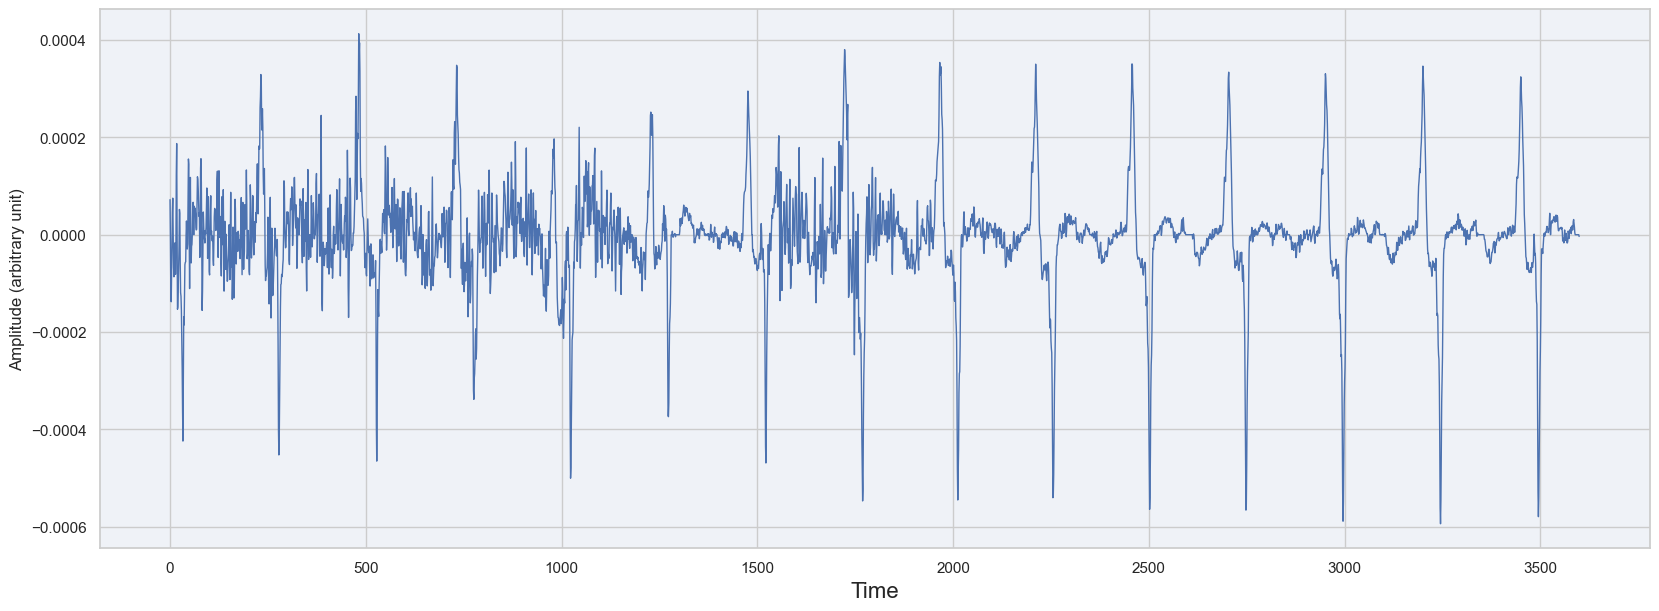

In [122]:
plt.figure(figsize=(20, 7))
start = 0
stop = 3600
duration = (stop-start) / settings['fs']
plt.plot(x[start:stop].index,x[start:stop].MLII,linewidth=1)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

In [132]:
def detect_peaks(ecg_signal, threshold=0.5, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 35)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    
    return ecg_signal[similarity > threshold].index, similarity


In [133]:
def get_plot_ranges(start=0, end=50, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

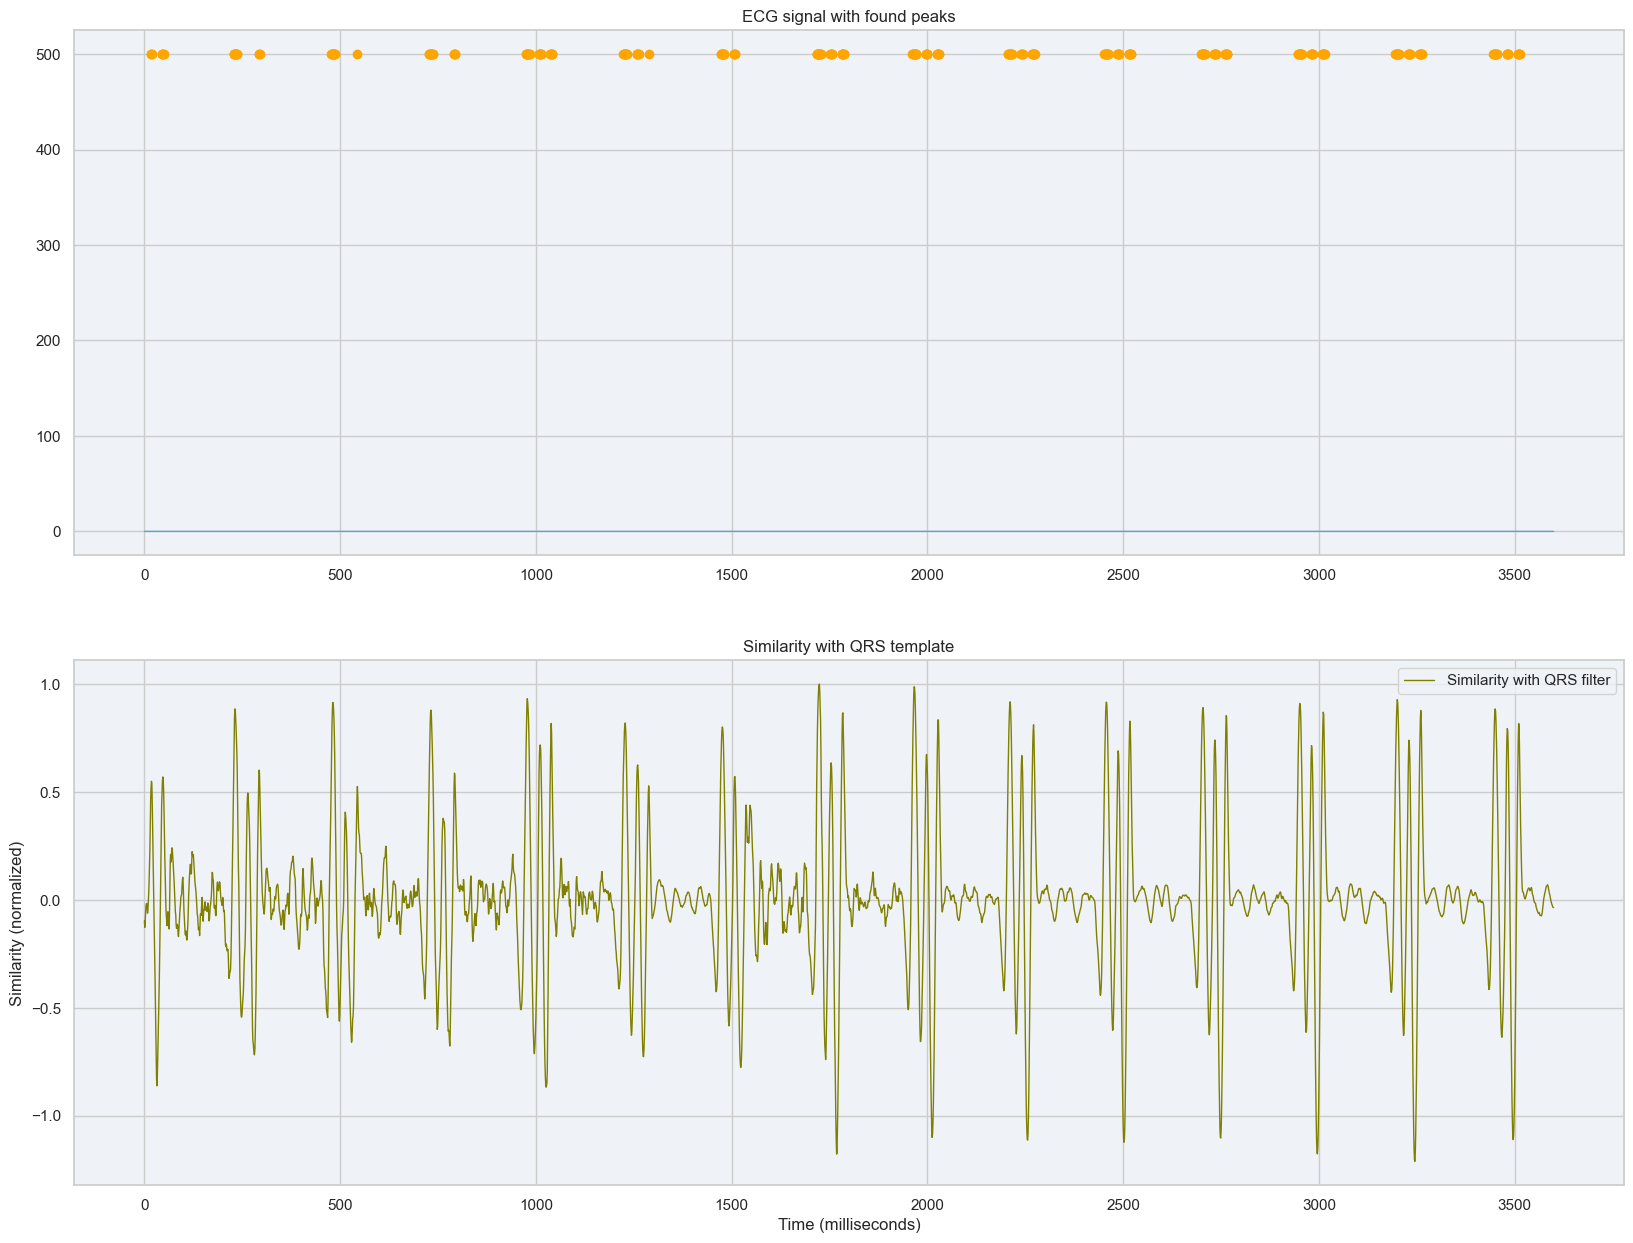

In [134]:
sampfrom = 0
sampto = 3600
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    cond_slice = (x.index >= start) & (x.index < stop) 
    ecg_slice = x.MLII[cond_slice]

    # detect peaks
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.5)
    
    # plot similarity
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(500, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
#     plt.legend(loc="upper right")
#     plt.xlabel("Time (milliseconds)")
#     plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")

In [135]:
peaks, similarity = detect_peaks(ecg_slice, threshold=0.5)
print(list(peaks))

[17, 18, 19, 45, 46, 47, 48, 49, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 292, 293, 294, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 544, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 791, 792, 793, 794, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1257, 1258, 1259, 1260, 1261, 1262, 1288, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1506, 1507, 1508, 1509, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1752, 1753, 1754, 1755, 1756, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1996, 1997, 1998, 1999, 2000, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2239, 2240, 2241, 2242, 2243, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2452, 2453

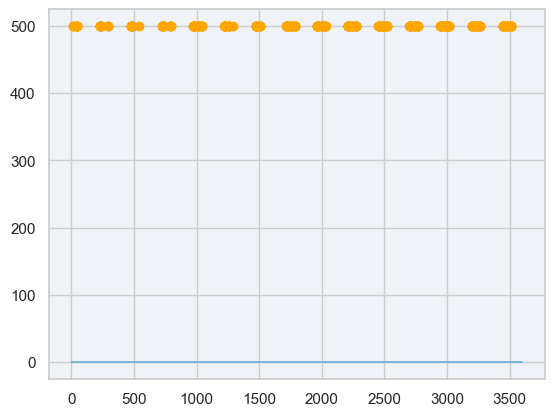

In [136]:
plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
plt.plot(peaks, np.repeat(500, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")

In [137]:
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

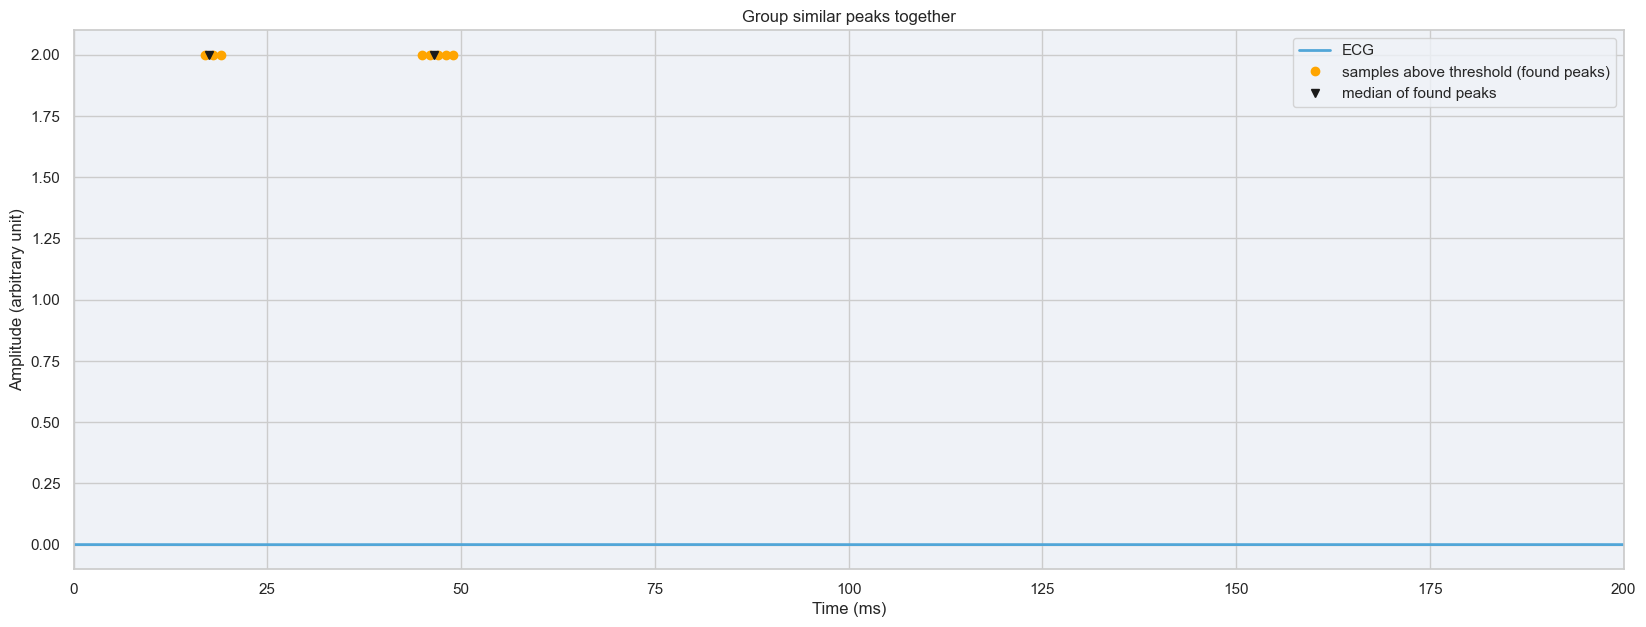

In [138]:
# detect peaks
peaks, similarity = detect_peaks(x.MLII, threshold=0.5)

# group peaks
grouped_peaks = group_peaks(peaks)

# plot peaks
plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(x.index, x.MLII, label="ECG", color="#51A6D8", linewidth=2)

plt.plot(peaks, np.repeat(2, peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(2, grouped_peaks.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (arbitrary unit)")
plt.gca().set_xlim(0, 200)
plt.show()

In [139]:
q=grouped_peaks
q

array([  17.5,   46.5,  232. ,  292.5,  481.5,  731.5,  792. ,  978.5,
       1010.5, 1038.5, 1227. , 1259. , 1476. , 1507. , 1722. , 1753.5,
       1783.5, 1966. , 1997.5, 2026.5, 2210.5, 2240.5, 2270. , 2456.5,
       2487. , 2516.5, 2703.5, 2734. , 2762.5, 2950.5, 2981. , 3011. ,
       3199.5, 3230. , 3259. , 3449.5, 3481. , 3510. , 3700.5, 3731. ])

In [140]:
len(q)

40

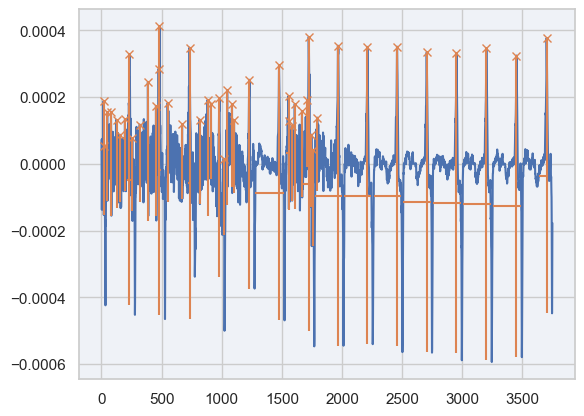

45


In [108]:
x = pd.read_csv("C:\\Users\\GauravUgale\\Downloads\\Exctracted_het.csv").iloc[:,-1].values[:]
peaks, properties = find_peaks(x, prominence=0.0002, width=0.05)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.vlines(x=peaks, ymin=x[peaks] - properties["prominences"], ymax = x[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"], xmax=properties["right_ips"], color = "C1")
plt.show()
print(len(peaks))

In [109]:
xx= len(peaks)-len(q)
xx

5

In [110]:
# import os 
# path = "C:\\Users\\GauravUgale\\Desktop\\ML_projects\\All_files_check\\"
# files = [x for x in os.listdir(path) if x.endswith('.csv')]

# data = {'FileName':[], 'std_devi':[]}

# for name in files:
#     name = name.split('.')[0]

#     header_list = ['MLII', 'Value', 'VALUE', 'ECG', '0', 'val','V1', 'II', 'noise1', 'noise2','ii']
#     for header in header_list:
#         try:
#             y = pd.read_csv(f'{path}{name}.csv')[header].values
#         except:
#             pass
#         if xx>= 5:
#             # plt.plot(y)
#             plt.savefig(f'C:\\Users\\GauravUgale\\Desktop\\test_to\\new_high\\{name}.jpg')
    
#         else:
#             # plt.plot(y)
#             plt.savefig(f'C:\\Users\\GauravUgale\\Desktop\\test_to\\new_normal\\{name}.jpg')
#         plt.close()